In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from lightning_modules.metalearn import MetaLearningTask
import torch
import matplotlib.pyplot as plt
import pyvene as pv
import numpy as np
import jax
import jax.random as jr
from wandb import Api
import pandas as pd
import seaborn as sns

# Compute KL curve

In [7]:
runs = Api().runs(
    path="leogagnon/latent_control",
    filters={
        "$or": [
            {"config.sweep_id": "start_at_n_real2025-01-30-11-29-43"},
        ]
    },
)
runs = [run.id for run in runs]

In [11]:
df = pd.DataFrame(
    columns=[
        "method",
        "model",
        "seed",
        "seq_id",
        "n_samples",
        "f_kl",
        "b_kl",
        "nll",
    ]
)

N_RUNS = 256
C_LEN = 200

for id in runs:
    task = MetaLearningTask(id).cuda()
    task: MetaLearningTask
    if task.cfg.data.start_at_n != None:
        method = 'suffix'
    else:
        method = 'normal'
    
    model = "GPT" if ('gpt' in task.cfg.model.tag) else "Mamba"

    pp_dict = task.evaluate_pp(samples=N_RUNS, n_steps=C_LEN, compare_to_known=True)

    for i in range(N_RUNS):
        for j in range(C_LEN):
            df.loc[len(df)] = {
                "method": method,
                "model": model,
                "seed": task.cfg.data.seed,
                "seq_id": i,
                "n_samples": j,
                "f_kl": pp_dict["ForwardKL"][i, j].item(),
                "b_kl": pp_dict["BackwardKL"][i, j].item(),
                #"nll": pp_dict["ModelNLL"][i, j].item(),
            }

Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 195.67it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 190.48it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 199.90it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 196.03it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 194.40it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 199.05it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 194.65it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 191.77it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 186.72it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 188.78it/s]


Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


256it [00:01, 197.94it/s]


In [12]:
df.to_csv("start_at_n.csv")

In [20]:
df['method'].unique()

array(['normal', 'suffix'], dtype=object)

<Axes: xlabel='n_samples', ylabel='b_kl'>

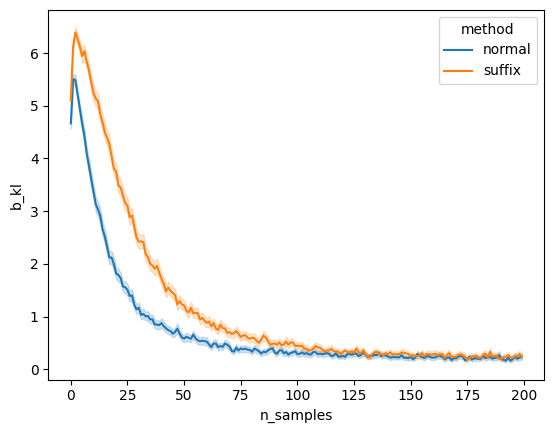

In [18]:
sns.lineplot(df[df['model']=='GPT'], x='n_samples', y='b_kl', hue='method')

<Axes: xlabel='n_samples', ylabel='b_kl'>

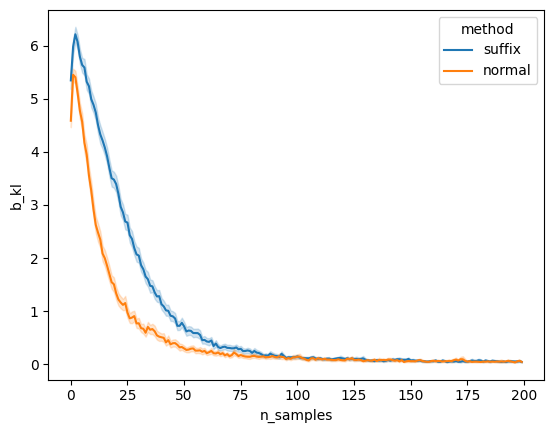

In [19]:
sns.lineplot(df[df['model']=='Mamba'], x='n_samples', y='b_kl', hue='method')

In [ ]:
sns.lineplot(df, x='n_samples', y='b_kl', hue='model')

In [2]:
run_dict = {'mamba_suf': '7j0nxf32', 'gpt_suf': 'og8o1iox', 'mamba': 'p0u4qks6', 'gpt': '29k6i5w1'}

In [29]:
dataset = MetaLearningTask(run_dict['mamba_suf']).full_data

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


In [40]:
envs = jr.choice(jr.PRNGKey(0), len(dataset), (100,))
Xs = jax.vmap(dataset.sample, (0, None, 0))(
    envs, 200, jr.split(jr.PRNGKey(0), len(envs))
)[0]

pps = {}
for run in run_dict.keys():
    task = MetaLearningTask(run_dict[run]).cuda()
    res = task.evaluate_pp(samples=Xs, envs=envs, compare_to_known=False)

    pps.update({run: res})

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


100it [00:41,  2.44it/s]


Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


100it [00:40,  2.47it/s]


Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


100it [00:40,  2.48it/s]


Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


100it [00:40,  2.49it/s]


In [63]:
task = MetaLearningTask('qffy1o38').cuda()

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


In [64]:
res = task.evaluate_pp(samples=100, n_steps=200, compare_to_known=True)

100it [00:01, 51.28it/s]


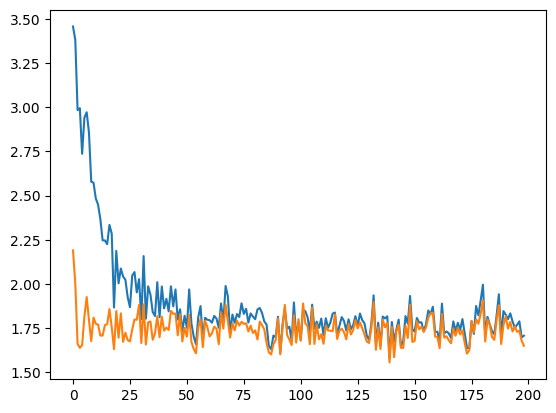

In [65]:
plt.plot(res['ModelNLL'].mean(0))
plt.plot(res['OracleNLL'].mean(0))

Text(0.5, 1.0, 'ModelNLL')

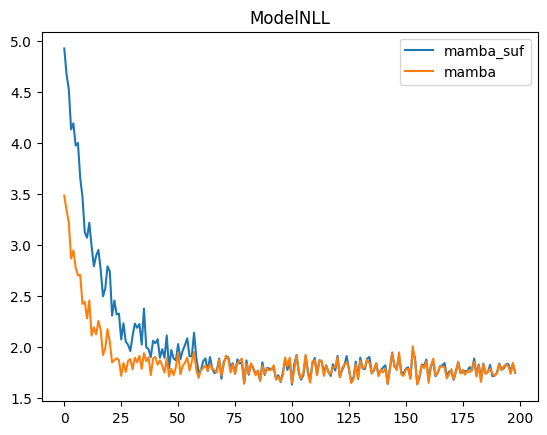

In [44]:
for run in run_dict.keys():
    if 'mamba' in run:
        plt.plot(pps[run]['ModelNLL'].mean(0), label=run)
plt.legend()
plt.title('ModelNLL')

In [12]:
pps

{'mamba_suf': {'ForwardKL': tensor([[1.0703e+00, 1.7100e+00, 3.2059e+00,  ..., 7.3562e-03, 2.1312e-02,
           5.2477e-02],
          [1.1610e+00, 1.2420e+00, 1.7916e+00,  ..., 3.8129e-03, 1.4092e-02,
           3.1683e-03],
          [1.0931e+00, 9.3747e-01, 6.4675e-01,  ..., 1.2745e-03, 1.3714e-02,
           1.2584e-02],
          ...,
          [1.0703e+00, 8.2923e-01, 7.5822e-01,  ..., 5.6457e-03, 8.2851e-03,
           8.2453e-03],
          [1.9875e+00, 2.9652e-01, 1.2270e+00,  ..., 7.1985e-03, 3.2369e-02,
           4.5454e-02],
          [1.0703e+00, 1.0405e+00, 1.1861e+00,  ..., 1.3429e-03, 8.9132e-03,
           1.1439e-03]]),
  'BackwardKL': tensor([[4.9874e-01, 8.0355e-01, 1.5035e+00,  ..., 1.0372e-02, 2.5768e-02,
           1.4887e-01],
          [7.9880e-01, 7.2388e-01, 1.2326e+00,  ..., 3.6857e-03, 1.4761e-02,
           3.5487e-03],
          [5.4658e-01, 7.4057e-01, 3.0776e-01,  ..., 5.9836e-04, 1.3805e-02,
           1.6842e-02],
          ...,
          [4.9874e-

# Extract hidden states with pyvene

In [ ]:
data = task.full_data

ids = torch.randperm(len(data))
train_ids = ids[:60000][torch.randint(0,60000,(200000,))]
val_ids = ids[60000:]
val_ids = val_ids[torch.randint(0,len(val_ids),(50000,))]

train_data = data.__getitems__(train_ids, length=200)['input_ids']
val_data = data.__getitems__(val_ids, length=200)['input_ids']

In [6]:
task.model.config.ssm_cfg = dict(task.model.config.ssm_cfg)
task.model.config = PretrainedConfig.from_dict(dataclasses.asdict(task.model.config))

In [18]:
all_ids = torch.arange(len(task.full_data))
some_ids = torch.randperm(len(task.full_data))[:100]

In [23]:
repr_configs = [
    pv.RepresentationConfig(
        component=f"backbone.layers[{i}].mixer.output",
        intervention=pv.CollectIntervention(embed_dim=384, keep_last_dim=True),
    )
    for i in range(6)
]
intv_model = pv.IntervenableModel(pv.IntervenableConfig(repr_configs), model=task.model)

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:595: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [26]:
input_ids = task.full_data.__getitems__(torch.repeat_interleave(some_ids,100), length=300)['input_ids']
latents = []
for batch in tqdm(torch.chunk(input_ids, 100)):
    intv_out = intv_model(
        base=BatchEncoding({"input_ids": batch, "only_last_logits": False}),
        unit_locations={"sources->base": [[[i for i in range(300)]]]},
    )
    latents += [torch.stack(list(intv_out[0][1].values()),-2)[:, [0,9,19,29,39,49,99,199,299]].cpu()]

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]
